# 字符串操作

In [1]:
import re
text='foo   bar\tbaz \tqux'
re.split('\s+',text)  # \s+表示分隔符为数量不定的一组空白符（制表符、空格、换行符等）

['foo', 'bar', 'baz', 'qux']

In [2]:
text1='foo  bar\nbaz \n\tqux'
re.split('\s+',text1)

['foo', 'bar', 'baz', 'qux']

In [3]:
regex=re.compile('\s+')   #re.compile编译之后可以重用
regex.split(text)

['foo', 'bar', 'baz', 'qux']

In [4]:
regex.findall(text1)   #得到匹配regex的所有模式，就是该字符串中所有用来分隔的分隔符

['  ', '\n', ' \n\t']

In [60]:
text="""dave dave@google.c|om 
steve steve@gmail.com|mmm 
rob rob@gmail.commmm 
ryan ryan@yahoo.com"""
pattern=r'[A-Z0-9._%]+@[A-Z0-9.-]+\.[A-Z]{2,7}'   
#表示最少取2个，最多取7个，要是碰到不是[]内的也终止，提前碰到不是[]内的也终止。正则表达式\.用来匹配点字符，而不是任何字符的通配符
regex=re.compile(pattern,flags=re.IGNORECASE)
regex.findall(text)

['steve@gmail.com', 'rob@gmail.commmm', 'ryan@yahoo.com']

In [11]:
regex.sub('REDACTED',text)

'dave REDACTED \nsteve REDACTED \nrob REDACTED \nryan REDACTED'

In [12]:
pattern=r'([A-Z0-9._%]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'   #各部分加上小括号就可以实现分隔
regex=re.compile(pattern,flags=re.IGNORECASE)
regex.findall(text)

[('dave', 'google', 'com'),
 ('steve', 'gmail', 'com'),
 ('rob', 'gmail', 'com'),
 ('ryan', 'yahoo', 'com')]

In [25]:
pattern1=r'''
(?P<username>[A-Z0-9._%+-]+)
@
(?P<domain>[A-Z0-9.-]+)
\.
(?P<suffix>[A-Z]{2,4})'''
regex1=re.compile(pattern1,flags=re.IGNORECASE|re.VERBOSE)

In [26]:
m=regex1.match('wesm@bright.net')
m.groupdict()

{'domain': 'bright', 'suffix': 'net', 'username': 'wesm'}

In [43]:
regex1.search(text).groupdict()

{'domain': 'google', 'suffix': 'com', 'username': 'dave'}

#### pandas中矢量化的字符串函数

In [68]:
import pandas as pd
import numpy as np
data={'dave':'dave@google.com','steve':'steve@gmail.com',
      'rob':'rob@gmail.com','wes':np.nan}
data=pd.Series(data)
data.str.contains('gmail')

dave     False
rob       True
steve     True
wes        NaN
dtype: object

In [79]:
pattern=r'([A-Z0-9._%]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex=re.compile(pattern,flags=re.IGNORECASE)
matches=data.str.findall(regex)
matches

dave     [(dave, google, com)]
rob        [(rob, gmail, com)]
steve    [(steve, gmail, com)]
wes                        NaN
dtype: object

In [75]:
pattern=r'([A-Z0-9._%]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex=re.compile(pattern,flags=re.IGNORECASE)
matches=data.str.match(regex)
matches

dave     True
rob      True
steve    True
wes       NaN
dtype: object

# CASE: USDA food analysis

In [1]:
import json
db=json.load(open('pydata-book-2nd-edition/datasets/usda_food/database.json'))

In [6]:
import pandas as pd
import numpy as np
nutrients=pd.DataFrame(db[0]['nutrients'])

In [16]:
nutrients.head()

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00


In [11]:
db[0].keys()

[u'portions',
 u'description',
 u'tags',
 u'nutrients',
 u'group',
 u'id',
 u'manufacturer']

In [19]:

portions=pd.DataFrame(db[1]['portions'])
portions

,amount,grams,unit
0,1,132.00,"cup, diced"
1,2,244.00,"cup, melted"
2,3,113.00,"cup, shredded"
3,4,28.35,oz
4,5,17.00,cubic inch
5,6,28.00,slice (1 oz)


In [15]:
info_keys=['description','group','id','manufacturer']
info=pd.DataFrame(db,columns=info_keys)
info.head()

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [20]:
info.group.value_counts()[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Fruits and Fruit Juices              328
Pork Products                        328
Name: group, dtype: int64

In [22]:
nutrients=[]
for rec in db:
    fnut=pd.DataFrame(rec['nutrients'])
    fnut['id']=rec['id']
    nutrients.append(fnut)
nutrients=pd.concat(nutrients,ignore_index=True)
nutrients.head()

,description,group,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008


In [23]:
nutrients.duplicated().sum()

14179

In [24]:
nutrients=nutrients.drop_duplicates()

In [26]:
col_mapping={'description':'food','group':'fgroup'}
info=info.rename(columns=col_mapping,copy=False)

In [38]:
ndata=pd.merge(nutrients,info,on='id',how='outer')
ndata1=ndata[['id','food','fgroup','manufacturer','description','group','units','value']]
ndata1.head()

,id,food,fgroup,manufacturer,description,group,units,value
0,1008,"Cheese, caraway",Dairy and Egg Products,,Protein,Composition,g,25.18
1,1008,"Cheese, caraway",Dairy and Egg Products,,Total lipid (fat),Composition,g,29.20
2,1008,"Cheese, caraway",Dairy and Egg Products,,"Carbohydrate, by difference",Composition,g,3.06
3,1008,"Cheese, caraway",Dairy and Egg Products,,Ash,Other,g,3.28
4,1008,"Cheese, caraway",Dairy and Egg Products,,Energy,Energy,kcal,376.00


In [41]:
data_mapping={'description':'nutrient','group':'nutgroup'}
ndata1=ndata1.rename(columns=data_mapping,copy=False)
ndata1.head()

,id,food,fgroup,manufacturer,nutrient,nutgroup,units,value
0,1008,"Cheese, caraway",Dairy and Egg Products,,Protein,Composition,g,25.18
1,1008,"Cheese, caraway",Dairy and Egg Products,,Total lipid (fat),Composition,g,29.20
2,1008,"Cheese, caraway",Dairy and Egg Products,,"Carbohydrate, by difference",Composition,g,3.06
3,1008,"Cheese, caraway",Dairy and Egg Products,,Ash,Other,g,3.28
4,1008,"Cheese, caraway",Dairy and Egg Products,,Energy,Energy,kcal,376.00


<IPython.core.display.Javascript object>


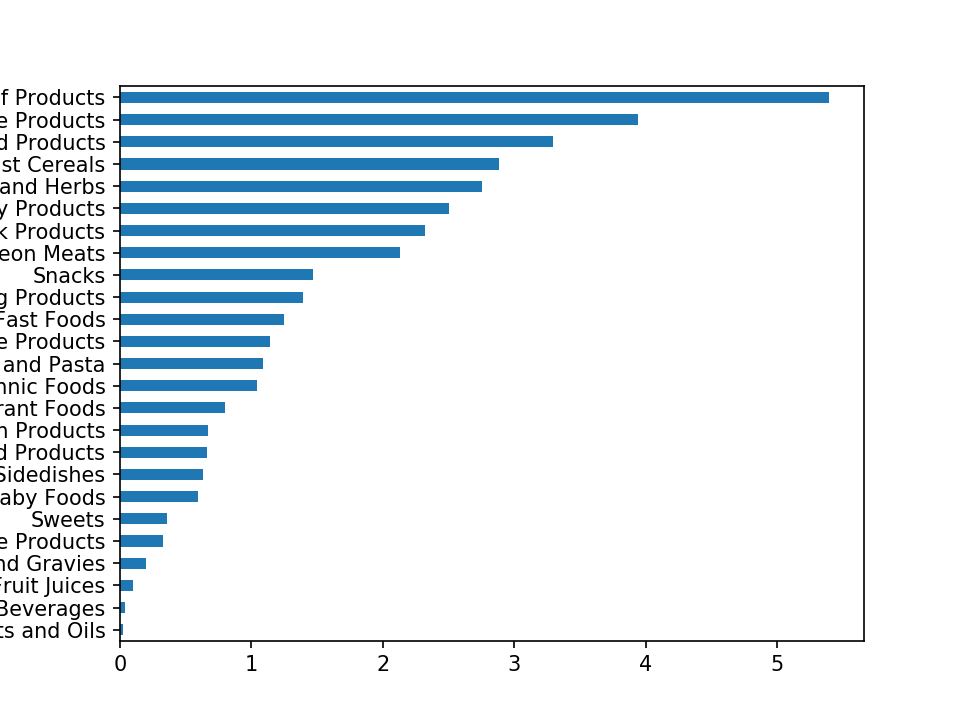

In [48]:
%matplotlib notebook
import matplotlib
result=ndata1.groupby(['nutrient','fgroup'])['value'].quantile(0.5)
result['Zinc, Zn'].sort_values().plot(kind='barh')

In [57]:
by_nutrient=ndata1.groupby(['nutgroup','nutrient'])
get_maximum=lambda x: x.xs(x.value.idxmax())
max_food=by_nutrient.apply(get_maximum)[['value','food']]
max_food.food=max_food.food.str[:50]
max_food.head()

value  \
nutgroup    nutrient                
Amino Acids Alanine         8.009   
            Arginine        7.436   
            Aspartic acid  10.203   
            Cystine         1.307   
            Glutamic acid  17.452   

                                                                   food  
nutgroup    nutrient                                                     
Amino Acids Alanine                   Gelatins, dry powder, unsweetened  
            Arginine                       Seeds, sesame flour, low-fat  
            Aspartic acid                           Soy protein isolate  
            Cystine        Seeds, cottonseed flour, low fat (glandless)  
            Glutamic acid                           Soy protein isolate